In [1]:
from temds import tile
from osgeo import ogr
import geopandas as gpd
import numpy as np
import rioxarray as rio
from temds import worldclim
from temds import crujra
import xarray as xr

from pathlib import Path

from affine import Affine

from temds import downscalers
from temds import corrections

import matplotlib.pyplot as plt


In [2]:
c_tile = (7, 16)
tile_index = gpd.read_file('/media/rwspicer/data/V3/tem/00-aoi/tile-index/')
hdx = tile_index['H'] == c_tile[0]
vdx = tile_index['V'] == c_tile[1]
bounds = tile_index[vdx & hdx].bounds
minx, maxx, miny, maxy = bounds[['minx','maxx','miny','maxy']].iloc[0]
minx, maxx, miny, maxy

(-1678000.0, -1402000.0, 2915000.0, 3315000.0)

In [3]:
wc_arctic = worldclim.WorldClim('/media/rwspicer/data/V3/tem/02-arctic/worldclim/worldclim-arctic.nc')

In [4]:
wc_arctic.dataset.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",90],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH],AUTHORITY["EPSG","6931"]]')

In [5]:

annual_list = []
for cru_file in list(Path('/media/rwspicer/data/V3/tem/02-arctic/cru-jra/').glob('*.nc')):
    year = int(cru_file.name.split('.')[-4])
    if year < 1970 or year > 1980:
        continue

    temp = crujra.AnnualDaily(year,cru_file, verbose=False)
    # temp.reproject(tile_index.crs.to_wkt())
    annual_list.append(temp)

annual_list[:5]

[CRUJRAnnualDaily: 1975,
 CRUJRAnnualDaily: 1980,
 CRUJRAnnualDaily: 1978,
 CRUJRAnnualDaily: 1979,
 CRUJRAnnualDaily: 1972]

In [6]:
cru_arctic_ts = crujra.AnnualTimeSeries(annual_list)

In [7]:
cru_arctic_ts[1970:1975]

AnnualTimeSeries
-CRUJRAnnualDaily: 1970
-CRUJRAnnualDaily: 1971
-CRUJRAnnualDaily: 1972
-CRUJRAnnualDaily: 1973
-CRUJRAnnualDaily: 1974

In [8]:
mytile = tile.Tile(c_tile, bounds, 4000, tile_index.crs.to_wkt(), buffer_px=20)

In [9]:
mytile.import_normalized('worldclim', wc_arctic)

wc = mytile.data['worldclim'].rename({'lat':'y', 'lon':'x'})
wc = wc.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)\
                     .rio.write_crs(tile_index.crs.to_wkt(),inplace=True)\
                     .rio.write_coordinate_system(inplace=True) 
wc = wc.reindex(y=list(reversed(wc.y)))
mytile.data['worldclim'] = wc

In [10]:
mytile.import_normalized('cru_AnnualTimeSeries', cru_arctic_ts)

CRUJRAnnualDaily: 1970 clipping
CRUJRAnnualDaily: 1971 clipping
CRUJRAnnualDaily: 1972 clipping
CRUJRAnnualDaily: 1973 clipping
CRUJRAnnualDaily: 1974 clipping
CRUJRAnnualDaily: 1975 clipping
CRUJRAnnualDaily: 1976 clipping
CRUJRAnnualDaily: 1977 clipping
CRUJRAnnualDaily: 1978 clipping
CRUJRAnnualDaily: 1979 clipping
CRUJRAnnualDaily: 1980 clipping


In [11]:
mytile.data['cru_AnnualTimeSeries']

for year in range(1970,1981):
    mytile.data['cru_AnnualTimeSeries'][year].dataset['x'] = wc.x
    mytile.data['cru_AnnualTimeSeries'][year].dataset['y'] = wc.y



mytile.calculate_climate_baseline(1970, 1975, 'cru_baseline', 'cru_AnnualTimeSeries')

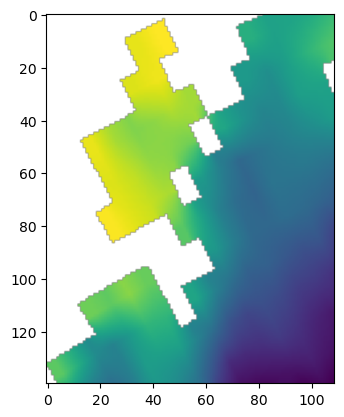

In [12]:
# img = mytile.data['cru_AnnualTimeSeries'][1970].dataset['tmax'].data[0]
img = mytile.data['cru_baseline']['tmax'].data[0]
# img = mytile.data['worldclim']['tmax'].data[0]

plt.imshow(img)

In [13]:
# mytile.save('/media/rwspicer/data/V3/tem/03-tiles-testing', overwrite=True)

In [14]:
variables = {
    'tmax': {'function': 'temperature', 'reference': 'tmax','baseline':'tmax', 'name': 'tmax'},
    'tmin': {'function': 'temperature', 'reference': 'tmin','baseline':'tmin', 'name': 'tmin'},
    'tavg': {'function': 'temperature', 'reference': 'tavg','baseline':'tmp', 'name': 'tavg'},
    'prec': {'function': 'precipitation', 'reference': 'prec','baseline':'pre', 'name': 'prec'},
}


mytile.calculate_correction_factors('cru_baseline', 'worldclim', variables)

In [15]:
# variables = {
#     'tmax': {'function': 'temperature', 'temperature': 'tmax','correction_factor':'tmax', 'name': 'tmax'},
#     'tmin': {'function': 'temperature', 'temperature': 'tmin','correction_factor':'tmin', 'name': 'tmin'},
#     'tavg': {'function': 'temperature', 'temperature': 'tmp','correction_factor':'tavg', 'name': 'tavg'},
#     'prec': {'function': 'precipitation', 'precipitation': 'pre','correction_factor':'prec', 'name': 'prec'},
# }

# year = 1970

# self = mytile
# source_id, baseline_id, reference_id ='cru_AnnualTimeSeries','cru_baseline', 'worldclim'
# reference = self.data[reference_id]
# baseline = self.data[baseline_id]
# source = self.data[source_id][year].dataset
# temp = []
# for var, info in variables.items():
#     func = downscalers.LOOKUP[info['function']]
#     current = func(baseline, reference, info)
#     current.name = info['name']
#     temp.append(current)
   
# downscaled = xr.merge(temp)
# downscaled


In [16]:
variables = {
    'tmax': {'function': 'temperature', 'temperature': 'tmax','correction_factor':'tmax', 'name': 'tmax'},
    'tmin': {'function': 'temperature', 'temperature': 'tmin','correction_factor':'tmin', 'name': 'tmin'},
    'tavg': {'function': 'temperature', 'temperature': 'tmp','correction_factor':'tavg', 'name': 'tavg'},
    'prec': {'function': 'precipitation', 'precipitation': 'pre','correction_factor':'prec', 'name': 'prec'},
}

year = 1970
downscaled = mytile.downscale_year(year, 'cru_AnnualTimeSeries','cru_baseline', 'worldclim', variables)

In [23]:
downscaled

<xarray.Dataset> Size: 3MB
Dimensions:      (x: 109, y: 140, time: 12)
Coordinates:
  * x            (x) float64 872B -1.756e+06 -1.752e+06 ... -1.324e+06
  * y            (y) float64 1kB 3.393e+06 3.389e+06 ... 2.841e+06 2.837e+06
  * time         (time) int64 96B 1 32 60 91 121 152 182 213 244 274 305 335
    spatial_ref  int64 8B 0
Data variables:
    tmax         (time, y, x) float32 732kB nan nan nan ... -11.75 -11.86 -11.96
    tmin         (time, y, x) float32 732kB nan nan nan ... -17.54 -17.64 -17.72
    tavg         (time, y, x) float32 732kB nan nan nan ... -17.16 -17.29 -17.42
    prec         (time, y, x) float32 732kB nan nan nan ... 4.407 4.185 4.161

In [24]:
not_downscaled

<xarray.Dataset> Size: 201MB
Dimensions:      (time: 365, y: 140, x: 109)
Coordinates:
  * x            (x) float64 872B -1.756e+06 -1.752e+06 ... -1.324e+06
  * y            (y) float64 1kB 3.393e+06 3.389e+06 ... 2.841e+06 2.837e+06
  * time         (time) object 3kB 1970-01-01 00:00:00 ... 1970-12-31 00:00:00
    spatial_ref  int64 8B 0
Data variables:
    tmin         (time, y, x) float32 22MB nan nan nan nan ... 244.8 244.8 244.8
    tmax         (time, y, x) float32 22MB nan nan nan nan ... 253.1 253.1 253.1
    tmp          (time, y, x) float32 22MB nan nan nan nan ... 245.7 245.7 245.6
    pre          (time, y, x) float32 22MB 0.0 0.0 0.0 ... 0.004432 0.005281
    dswrf        (time, y, x) float32 22MB 0.0 0.0 0.0 ... 7.522e+05 7.535e+05
    ugrd         (time, y, x) float32 22MB nan nan nan ... -1.5 -1.389 -1.281
    vgrd         (time, y, x) float32 22MB nan nan nan ... 0.4701 0.4181 0.3635
    spfh         (time, y, x) float32 22MB nan nan nan ... 0.0001024 0.0001029
    pres         (time, y, x) float32 22MB nan nan nan ... 9.42e+04 9.457e+04
Attributes:
    CDI:              Climate Data Interface version 1.9.9 (https://mpimet.mp...
    Conventions:      CF-1.4
    source:           Data is provided from the Japanese 55-year Reanalysis (...
    institution:      Produced at the Climatic Research Unit, UEA, Norwich UK
    title:            CRUJRA TMIN: a forcing dataset based on CRU TS v4.08 an...
    version_control:  V2.5: Update to 2026 with partial alignment to CRU TS v...
    history:          Sat Jun 29 02:26:42 2024: cdo -L -s copy /media/f098/bi...
    references:       Contact i.harris@uea.ac.uk with any questions
    comment:          JRA-55 regridded to CRU 0.5 grid and aligned with CRU T...
    contact:          i.harris@uea.ac.uk
    CDO:              Climate Data Operators version 1.9.9 (https://mpimet.mp...

In [47]:
# self = mytile
# wc = self.data['worldclim'].rename({'lat':'y', 'lon':'x'})
# wc = wc.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)\
#                      .rio.write_crs(tile_index.crs.to_wkt(),inplace=True)\
#                      .rio.write_coordinate_system(inplace=True) 
# wc = wc.reindex(y=list(reversed(wc.y)))
# cru_baseline= self.data['cru_avg']

# cru_baseline['x'] = wc.x # I need to fix this
# cru_baseline['y'] = wc.y

# # prec_cf =wc['tmax'] -( cruavg['tmax']- 273.15)
# temp = []

# for tid in ['tmax', 'tmin']:
#     temp.append(corrections.temperature(cru_baseline, wc, {'reference': tid, 'baseline':tid}))
#     temp[-1].name = f'corr-{tid}'
    
# temp.append(corrections.temperature(cru_baseline, wc, {'reference': 'tavg', 'baseline':'tmp'}))
# temp[-1].name = 'corr-tavg'

# temp.append(corrections.precipitation(cru_baseline, wc, {'reference': 'prec', 'baseline':'pre'}))
# temp[-1].name = 'corr-prec'

# correction_factors = xr.merge(temp)

In [65]:
# # from importlib import reload
# # reload(downscalers)
# temp = []
# not_downscaled = self.data['cru_AnnualTimeSeries'][1970].dataset
# not_downscaled['x'] = wc.x
# not_downscaled['y'] = wc.y

# for tid in ['tmax', 'tmin']:
#     temp_ds = downscalers.temperature(not_downscaled, correction_factors, {'temperature':tid, 'correction_factor': f'corr-{tid}'})
#     temp_ds.name = tid
#     temp.append(temp_ds)

# downscaled = xr.merge(temp)
# temp[2].name = 'tavg'

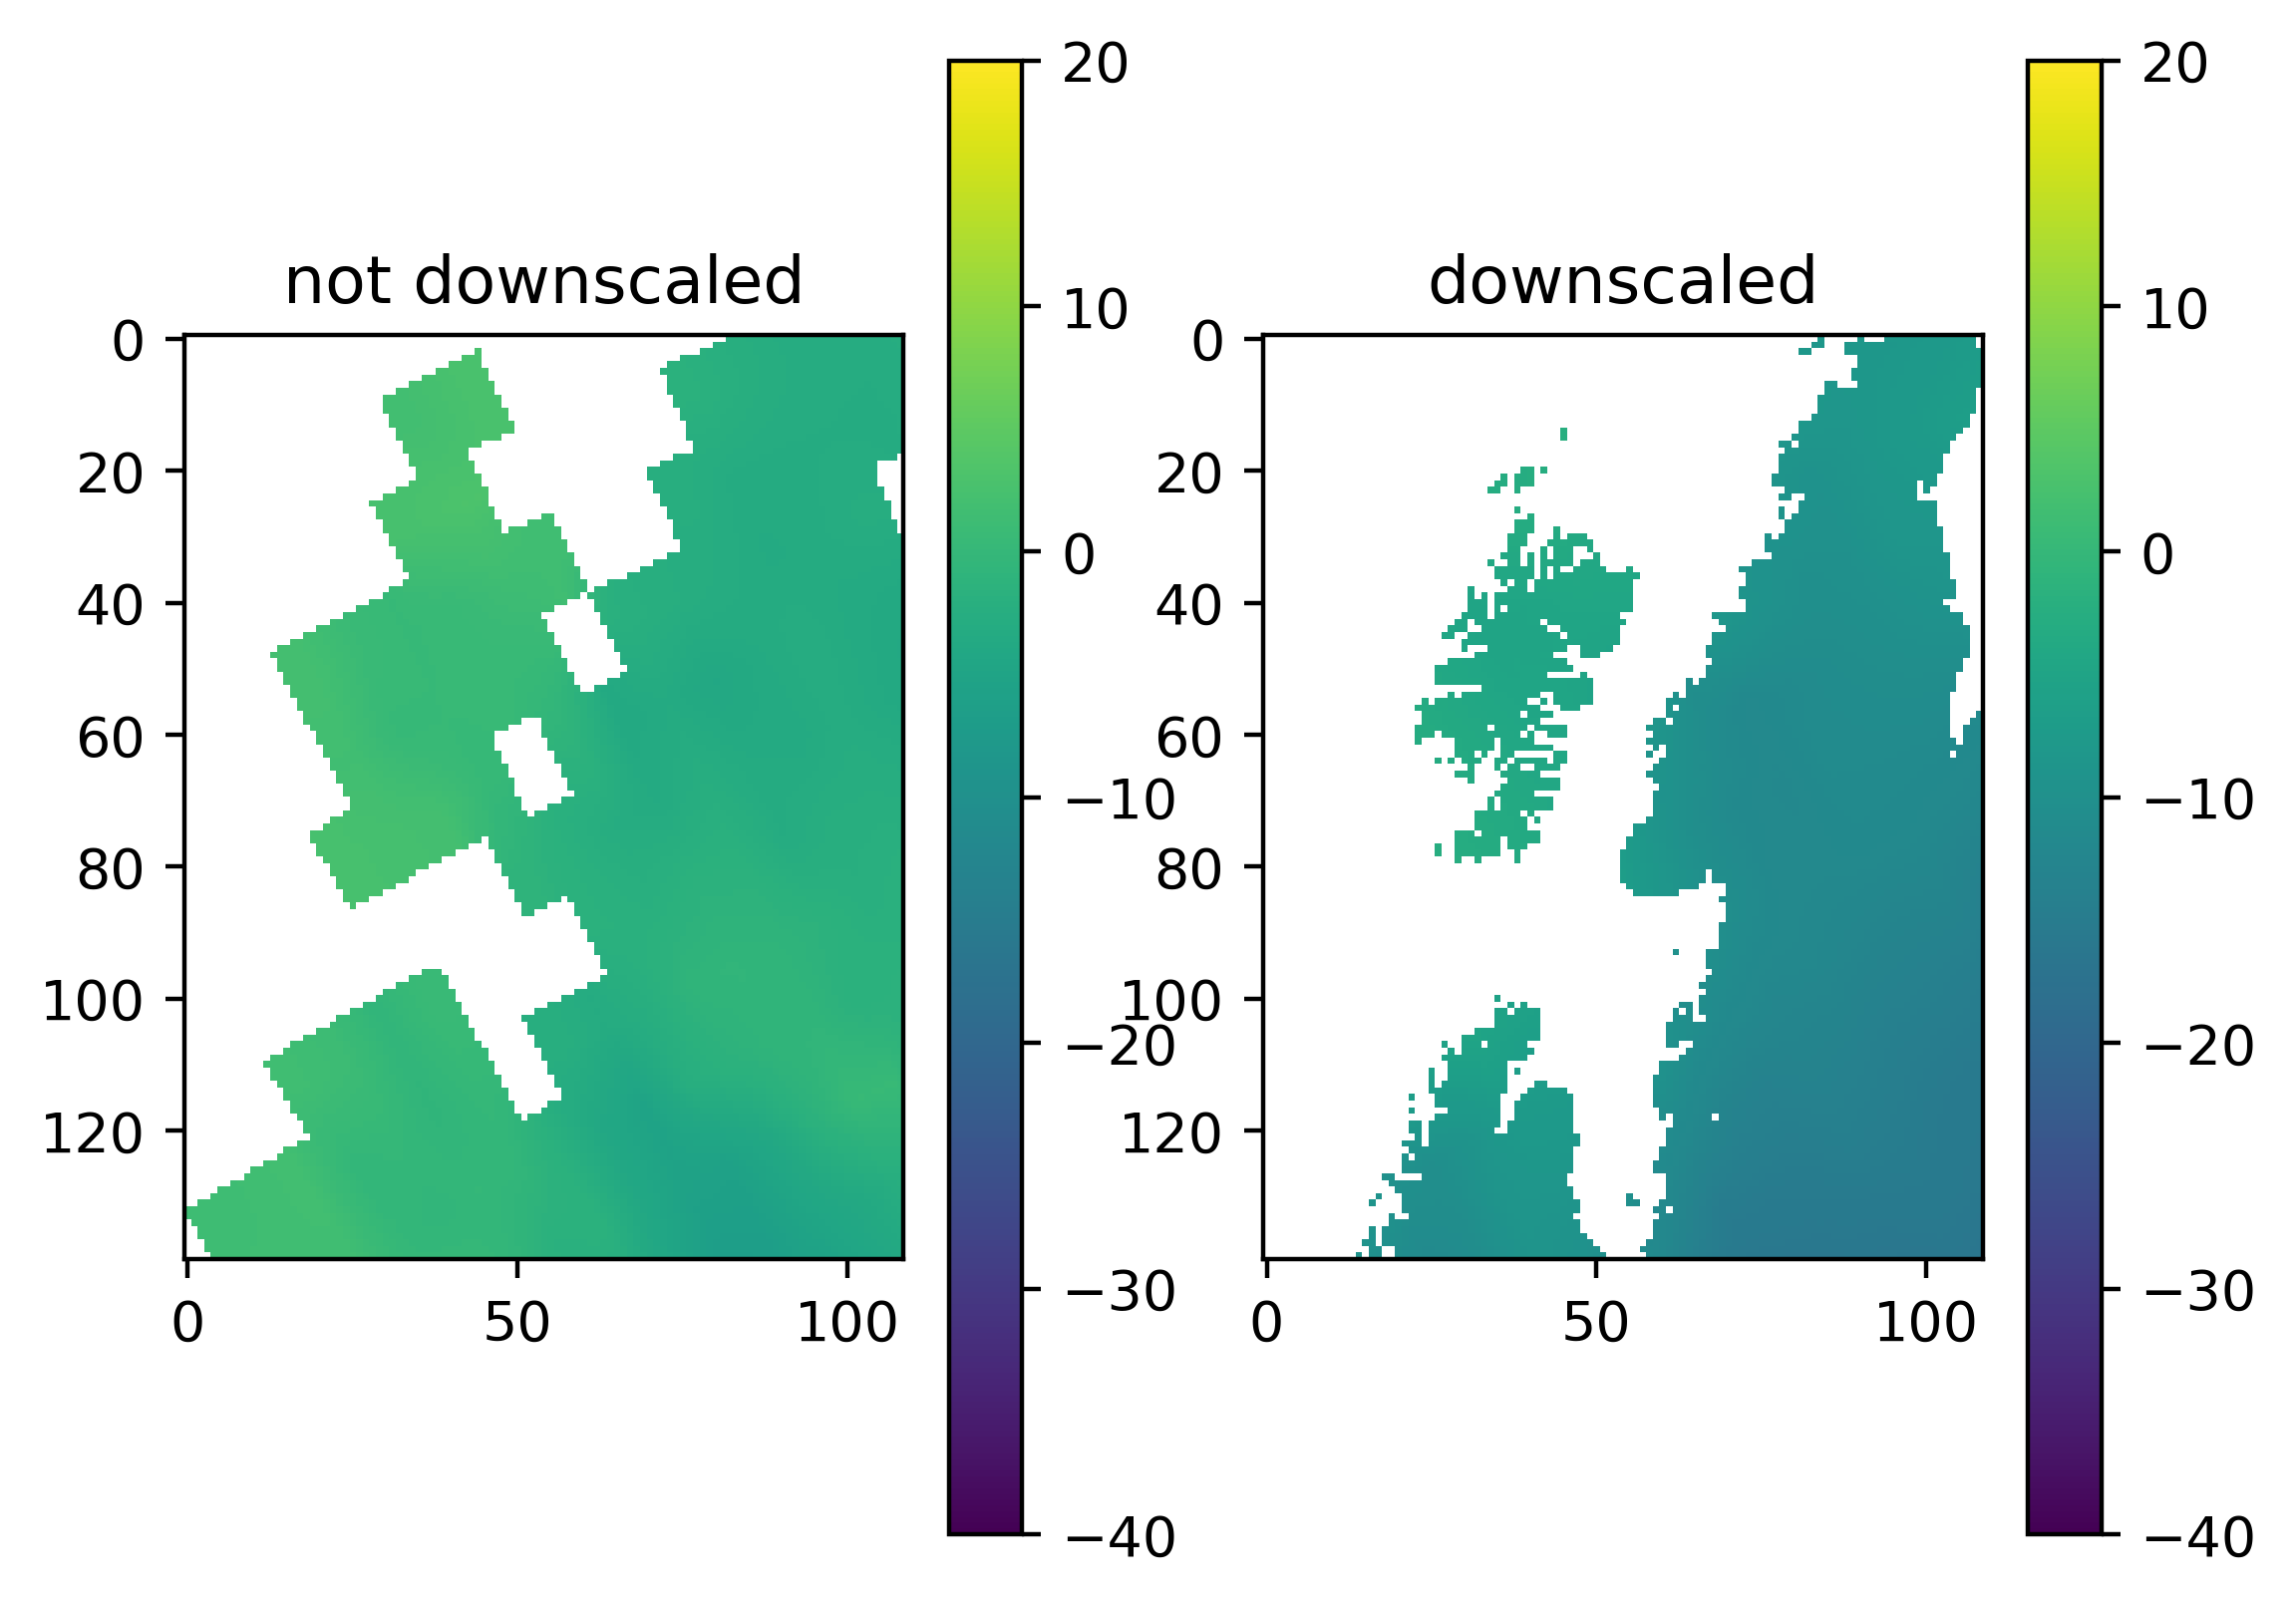

In [26]:
not_downscaled = mytile.data['cru_AnnualTimeSeries'][1970].dataset


fig, axes = plt.subplots(1,2, dpi=400)
axes[0].imshow(not_downscaled['tmax'].data[0] - corrections.ZERO_C_IN_K, vmin=-40, vmax=20)
axes[0].set_title('not downscaled')


im = axes[1].imshow(downscaled['tmax'].data[0], vmin=-40, vmax=20)
axes[1].set_title('downscaled')
fig.colorbar(im, ax=axes[1])
fig.colorbar(im, ax=axes[0])